<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            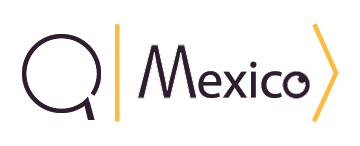
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Qiskit Optimization</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Diego Aguilar Muñoz</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Programas cuadráticos](#secc1)
3. [Optimizador del algoritmo de Grover](#secc2)
   1. [Búsqueda Adaptada de Grover (GAS)](#secc2.1)
   2. [Minimizar un problema QUBO](#secc2.2)
4. [Referencias](#secc3)

<a id="intro"></a>
# Introducción

Qiskit Optimization es un módulo que cubre un amplio rango de optimizaciones. Desde modelado de alto nivel de problemas de optimización hasta algoritmos cuánticos de optimización listos para correr tanto en simuladores como dispositivos reales.

Este módulo permite modelar fácilmente problemas cuadráticos por medio de <a href="https://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html">docplex</a>, permitiendo resolverlos con una gran variedad de algoritmos cuánticos variacionales como el Algoritmo de Optimización Aproximada Cuántica (Quantum Approximate Optimization Algorithm, QAOA) o la Búsqueda Adaptada de Grover (Grover Adaptive Search, GAS).

Qiskit Optimization se divide en 3 principales submódulos:

1. **Problems**: Define estructuras para modelar problemas de optimización tales como programas cuadráticos.

2. **Algorithms**: Este submódulo se centra en algoritmos de optimización de problemas.

3. **Converters**: Busca transformar diferentes programas cuadráticos a otras representaciones e interpretarlas.

En este Notebook tendremos como objetivo aprender a modelar un programa cuadrático y aplicar un algoritmo de optimización, en este caso GAS.

In [1]:
from qiskit import BasicAer
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer

<a id="secc1"></a>
# Programas cuadráticos

Qiskit Optimization introduce la clase `QuadraticProgram` para poder modelar un programa cuadrático con constricciones cuadráticas. Este programa es tal que:

$$ \begin{align*}
\texttt{minimizar} \;\;\; &x^\top Q_0 x + c^\top\\
\texttt{sujeto a} \;\;\; &Ax \leq b \\
&x^\top Q_i x + a_i^\top x \leq r_i \\
&l_i \leq x_i \leq u_i
\end{align*} $$

 Donde $Q_i$ son matrices de $n \times n$. $A$ es una matriz de $m \times n$, $x$ y $c$ son vectores n-dimensionales, b es un vector m-dimensional y $x$ puede ser una variable binaria, entera o continua. Es importante recordar que $x^\top$ representa la transpuesta del vector $x$.

 Para aprender a modelar un programa cuadrático, podemos empezar creando un modelo vacío


In [2]:
# Definimos un modelo llamado "problema"

modelo = QuadraticProgram('problema')

# Podemos observar los componentes de nuestro modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj:
Subject To

Bounds
End



`QuadraticProgram` acepta 3 tipos de variables: variables binarias, enteros o variables continuas. Es importante que al declarar alguna variable se especifique el nombre, tipo, el límite inferior y el límite superior. Una forma muy cómoda de visualizar el modelo es en formato LP (para más información del formato LP puedes revisar este <a href="https://www.ibm.com/docs/en/icos/12.7.1.0?topic=cplex-lp-file-format-algebraic-representation">enlace</a>). En este formato `Binaries` representan variables binarias y `Generals` representan enteros. Si hay variables que no se encuentran en ninguno de estos 2, son variables continuas, a menos que se especifique sus límites serán de 0 a infinito. Es importante notar que por especificaciones del formato LP, ningún nombre puede tener 'e' o 'E' como primer caracter.

In [3]:
# Añadimos variables a nuestro modelo
modelo.binary_var(name='x')
modelo.integer_var(name='y', lowerbound=-1, upperbound=5)
modelo.continuous_var(name='z', lowerbound=-1, upperbound=5)

# Observamos los componentes de nuestro modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj:
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



Podemos definir la función objetivo utilizando `QuadraticProgram.minimize` o `QuadraticProgram.maximize`. Esto nos permite agregar constantes, términos lineales o cuadráticos por medio de listas, matrices o diccionarios. En el siguiente ejemplo mostramos cómo definir la función objetivo por medio de diccionarios. Para el término lineal, la clave del diccionario corresponde al nombre de la variable y su valor son los coeficientes. Para el término cuadrático, las claves corresponden a las 2 variables multiplicadas y su valor vuelven a ser los coeficientes.

Es importante notar que de acuerdo al formato LP, la parte cuadrática va a estar multiplicada por un factor de $\frac{1}{2}$. Por lo tanto, al imprimirla en este formato primero se va a multiplicar por 2 y después dividirla entre 2.

In [4]:
# Agregamos la función objetivo utilizando diccionarios
modelo.minimize(constant=3, linear={'x': 1}, quadratic={('x', 'y'): 2, ('z', 'z'): -1})

# Visualizamos el modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



En el siguiente ejemplo mostramos cómo definir una función objetivo utilizando arreglos. Para el término lineal el arreglo corresponde al vector $c$ en la expresión matemática. Para el término cuadrático, el arreglo corresponde a la matriz $Q$. Es importante notar que el orden de las variables va conforme fueron declaradas en pasos anteriores.

In [5]:
# Agregamos una función objetivo utilizando la matriz que define al problema cuadrático
modelo.minimize(constant=3, linear=[1,0,0], quadratic=[[0,1,0],[1,0,0],[0,0,-1]])

# Visualizamos el modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



Se pueden obtener los valores de la constante, término lineal y cuadrático utilizando `Quadratic.objective.{constant, lineal, quadratic}` respectivamente. En el caso del término lineal y cuadrático, se obtiene una matriz de densidad (`to_array`), una matriz de esparcimiento (`coefficients`) y un diccionario (`to_dict`). Para los diccionarios, se puede especificar si se ocupan indices o nombres como clave. Es importante notar que los términos cuadráticos se guardan en una notación comprimida, es decir `{('x', 'y'): 1, ('y','x'): 2}` se guarda como `{('x', 'y'): 3}`. Se puede obtener el término cuadrático como una matriz simétrica utilizando `to_array(symmetric=True)` o `to_dict(symmetric=True)`.

In [6]:
# Imprimimos la constante
print('constante:\t\t\t\t\t', modelo.objective.constant)
# Imprimimos el término lineal como diccionario
print('Término lineal como diccionario:\t\t', modelo.objective.linear.to_dict())
# Imprimimos el término lineal como arreglo
print('Término lineal como arreglo:\t\t\t', modelo.objective.linear.to_array())
# Imprimimos el término lineal como matriz de esparcimiento
print('Término lineal como matriz de esparcimiento:\n', modelo.objective.linear.coefficients, '\n')
# Imprimimos el término cuadrático como diccionario con índices
print('Término cuadrático con índices:\t\t\t', modelo.objective.quadratic.to_dict())
# Imprimimos el término cuadrático como diccionario con nombres de las variables
print('Término cuadrático con nombres:\t\t\t', modelo.objective.quadratic.to_dict(use_name=True))
# Imprimimos el término cuadrático simétrico con nombres
print('Término cuadrático simétrico con nombres:\t', modelo.objective.quadratic.to_dict(use_name=True, symmetric=True))
# Imprimimos el término cuadrático como matriz
print('Término cuadrático como matriz:\n', modelo.objective.quadratic.to_array(),'\n')
# Imprimimos el término cuadrático como matriz simétrica
print('Término cuadrático como matriz simétrica:\n', modelo.objective.quadratic.to_array(symmetric=True),'\n')
# Imprimimos el término cuadrático como matriz de esparcimiento
print('Término cuadrático como matriz de esparcimiento:\n', modelo.objective.quadratic.coefficients)


constante:					 3
Término lineal como diccionario:		 {0: 1}
Término lineal como arreglo:			 [1 0 0]
Término lineal como matriz de esparcimiento:
   (0, 0)	1 

Término cuadrático con índices:			 {(0, 1): 2, (2, 2): -1}
Término cuadrático con nombres:			 {('x', 'y'): 2, ('z', 'z'): -1}
Término cuadrático simétrico con nombres:	 {('y', 'x'): 1, ('x', 'y'): 1, ('z', 'z'): -1}
Término cuadrático como matriz:
 [[ 0  2  0]
 [ 0  0  0]
 [ 0  0 -1]] 

Término cuadrático como matriz simétrica:
 [[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]] 

Término cuadrático como matriz de esparcimiento:
   (0, 1)	2
  (2, 2)	-1


Se pueden agredar constricciones lineales utilizando el método `lineal_constraint()` cuyo argumento toma el nombre, expresión matemática, sentido y su *valor del lado derecho* (RHS). Por ejemplo:

In [7]:
# Añadimos constantes lineales
modelo.linear_constraint(linear={'x': 1, 'y': 2}, sense='==', rhs=3, name='lin')
modelo.linear_constraint(linear={'x': 1, 'y': 2}, sense='<=', rhs=3, name='lin_leq')
modelo.linear_constraint(linear={'x': 1, 'y': 2}, sense='>=', rhs=3, name='lin_geq')

#Visualizamos el modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin: x + 2 y = 3
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



De manera análoga para añadir constricciones cuadráticas se utiliza el método `quadratic_constraint`. Por ejemplo

In [8]:
# Añadimos las constricciones cuadráticas
modelo.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='==', rhs=1, name='quad_eq')
modelo.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='<=', rhs=1, name='quad_leq')
modelo.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='>=', rhs=1, name='quad_geq')

#Visualizamos el modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin: x + 2 y = 3
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3
 quad_eq: [ x^2 - y*z ] + x + y = 1
 quad_leq: [ x^2 - y*z ] + x + y <= 1
 quad_geq: [ x^2 - y*z ] + x + y >= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



Para remover constricciones se ocupa el método `remove_linear_constraint()` o `remove_quadratic_constraint()` respectivamente. El argumento de cada método será el nombre de la constricción que se busca eliminar

In [9]:
# Remove constraints
modelo.remove_linear_constraint('lin')
modelo.remove_quadratic_constraint('quad_leq')

# Visualizamos el modelo
print(modelo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3
 quad_eq: [ x^2 - y*z ] + x + y = 1
 quad_geq: [ x^2 - y*z ] + x + y >= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



Finalmente, `QuadraticProgram` nos permite sustituir variables con constantes u otras variables. Para esto se utiliza el método `substitute_variables(constants=..., variables=...)`. Por ejemplo

In [10]:
# Sustituimos la variable x por la constante 0 y la variable y por -z 
substitucion = modelo.substitute_variables(constants={'x': 0}, variables={'y': ('z', -1)})

# Visualizamos el nuevo modelo
print(substitucion.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problema

Minimize
 obj: [ - 2 z^2 ]/2 + 3
Subject To
 lin_leq: - 2 z <= 3
 lin_geq: - 2 z >= 3
 quad_eq: [ z^2 ] - z = 1
 quad_geq: [ z^2 ] - z >= 1

Bounds
 -1 <= z <= 1
End



<a id="secc2"></a>
# Optimizador del algoritmo de Grover

La Búsqueda Adaptada de Grover (Grover Adaptive Search, GAS) ha sido explorada como una posible solución de problemas de optimización combinatoria junto con algorimos variacionales como el Solucionador Propio Cuántico Variacional (Variational Quantum Eigensolver, <a href="https://www.mustythoughts.com/variational-quantum-eigensolver-explained">VQE</a>) y el Algoritmo de Optimización Aproximada Cuántica (Quantum Approximate Optimization Algorithm, <a href="https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained">QAOA</a>). Este algoritmo aplica iterativamente la búsqueda de Grover para encontrar el valor óptimo de una función objetivo, utilizando el valor mejor conocido de la iteración anterior como límite. El oráculo adaptativo utilizado en GAS reconoce todos los valores por encima o debajo del límite actual, disminuyendo el tamaño de la búsqueda en cada iteración hasta encontrar un valor óptimo.

Para implementar este algoritmo vamos a utilizar el componente `GroverOptimizer` de Qiskit Optimization para minimizar un problema cuadrático binario sin constricciones (Quantum Unbounded Binary Operation, QUBO).

<a id="secc2.1"></a>
## Búsqueda Adaptada de Grover (GAS)

Sabemos que la búsqueda de Grover se compone de 3 ingredientes:

1. Operador para preparación de estado $A$ que busca construir una superposición de todos los estados en el espacio de búsqueda
2. El oráculo $O$, que reconoce los estados de interés y multiplica sus amplitudes por -1.
3. El operador de difusión de Grover $D$, que multiplica la amplitud del estado $\ket{0}_n$ por -1.

`GroverOptimizer` utiliza `QuadraticProgramToNegativeValueOracle` para construir $A_y$ de forma que prepara un registro de n qubits representando una superposición equitativa de todos los $\ket{x}_n$ y un registro de $m$ qubits para representar una aproximación del correspondiente $\ket{Q(x) - y}_m$ donde $Q(x)$ es la función que se busca minimizar y $y$ es el valor límite de la iteración anterior. Esto significa que todos los estados con $Q(x) - y$ negativa van a ser marcados por el oráculo. Formalmente `QuadraticProgramToNegativeValueOracle` produce:

$$ \begin{align*} A_y \ket{0}_n \ket{0}_m & = \frac{1}{\sqrt{2^n}} \sum_{x = 0}^{2^n-1} \ket{x}_n \ket{Q(x)-y}_m  \\ O \ket{x}_n \ket{z}_m & = sign(z) \ket{x}_n \ket{z}_m \end{align*}$$

En cada iteración se actualiza el límite $y$, por lo que $A_y$ cambia de forma que los valores de la función disminuyen o aumentan (dependiendo si se maximiza o minimiza) por $y$. Si quieres conocer con mayor detalle el funcionamiento de este algoritmo puedes revisar el siguiente <a href="https://arxiv.org/abs/1912.04088">artículo</a>.

<a id="secc2.2"></a>
## Minimizar un problema QUBO

Para este ejemplo podemos resolver el siguiente problema de minimización:

$$ min_{x \in \{ 0, 1\}^3} -2xz-yz-x+2y-3z $$

Podemos empezar definiendo el modelo de nuestro problema cuadrático como aprendimos en la sección anterior

In [11]:
# Definimos nuestro modelo
ejemplo = QuadraticProgram('QUBO')

# Añadimos nuestras variables binarias
ejemplo.binary_var(name='x')
ejemplo.binary_var(name='y')
ejemplo.binary_var(name='z')

#Añadimos la función objetivo
ejemplo.minimize(constant=0, linear={'x': -1, 'y':2, 'z':-3}, quadratic={('x', 'z'): -2, ('y', 'z'): -1})

# Visualizamos el modelo
print(ejemplo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: QUBO

Minimize
 obj: - x + 2 y - 3 z + [ - 4 x*z - 2 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



El siguiente paso es creal el `GroverOptimizer` que utiliza 6 qubits para codificar el valor y terminará después de 10 iteraciones del GAS sin progreso, es decir, sin modificar el valor de $y$. Para aplicar el optimizador a nuestro problema utilizamos el método `solve()` y regresa los resultados al ejecutar el algoritmo.

In [12]:
#Definimos el Backend sobre el cual vamos a ejecutar el programa
backend = BasicAer.get_backend('statevector_simulator')

# Definimos el optimizador de Grover
grover_opti = GroverOptimizer(6, num_iterations=10, quantum_instance=backend)

# Obtenemos los resultados de la ejecución en nuestro problema
resultados = grover_opti.solve(ejemplo)

# Imprimimos la solución de [x, y, z]
print("f(x) = {}".format(resultados.x))

# Imprimimos el valor objetivo óptimo
print("fval = {}".format(resultados.fval))

f(x) = [1. 0. 1.]
fval = -6.0


Por lo tanto los resultados de la optimización son $x=1$, $y=0$, $z=1$ y un valor objetivo óptimo de -6.

Podemos verificar este resultado utilizando `MinimumEigenOptimizer` en Qiskit ya que es un método exacto para obtener una minimización de un QUBO. Para más información de este método puedes consultar el siguiente <a href="https://qiskit.org/documentation/tutorials/optimization/3_minimum_eigen_optimizer.html">enlace</a>.

In [13]:
# Definimos el optimizador exacto o clásico
solución = MinimumEigenOptimizer(NumPyMinimumEigensolver())

# Obtenemos los resultados
resultado_e = solución.solve(ejemplo)

# Imprimimos la solución de [x, y, z]
print("x={}".format(resultado_e.x))

# Imprimimos la el valor objetivo óptimo
print("fval={}".format(resultado_e.fval))

x=[1. 0. 1.]
fval=-6.0


Por lo que `GroverOptimizer` nos entrega el mismo resultado que solucionando con `MinimumEigenOptimizer`

<a id="secc3"></a>
# Referencias

- [1] Qiskit Development Team. Qiskit Documentation: Qiskit's optimization module. Consultado en https://qiskit.org/documentation/apidoc/qiskit_optimization.html

- [2] Qiskit Development Team. Qiskit Tutorials: Quadratic Programs. Consultado en https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html
 
- [3] Qiskit Development Team. Qiskit Tutorials: Grover Optimizer. Consultado en https://qiskit.org/documentation/tutorials/optimization/4_grover_optimizer.html

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: right;">
            <a href="02_finance.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: Qiskit Finance >>
            </a>
            </div>
        </td>
    </tr>
</table>